In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [2]:
torch.__version__

'2.4.0'

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [5]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [6]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [7]:
words[:10]

['with eternity',
 'accept it and fixed the stake himself nicholas submitted to him and at',
 'line followed them across and the last cossacks quitted the farther side',
 '',
 '',
 '',
 'but send a courier to petersburg with news of a victory and general',
 'seen the lines of that mouth were remarkably finely curved the middle',
 'paris it was not calculation that guided her she did not even for a',
 'settled and i ought to have been off long ago here is something i have']

In [8]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [9]:
block_size = 5 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 5]), torch.int64, torch.Size([204978]), torch.int64)

In [11]:
emb_dim = 32
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[-0.8099, -0.0734, -1.6827,  ..., -0.0533,  0.4572, -0.3849],
        [-1.1558, -0.3560, -0.8009,  ..., -2.3032, -1.4628,  0.5944],
        [ 0.1583, -0.1534,  0.4166,  ..., -0.8154, -0.5163,  0.4451],
        ...,
        [ 1.0262, -0.5128, -0.3216,  ...,  0.2025, -0.7164, -0.4913],
        [ 0.7981,  0.4408, -0.7143,  ...,  0.9353,  0.7144, -0.1065],
        [ 1.3209, -1.0098,  0.2423,  ...,  1.4676, -1.3615, -0.3617]],
       requires_grad=True)

In [12]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.relu(self.lin1(x))
        x = self.lin2(x)
        return x 
    


In [13]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 1024).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1026 13:37:30.053000 135363969746752 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_30/64346145.py line 8 
W1026 13:37:30.053000 135363969746752 torch/_dynamo/convert_frame.py:1009] due to: 
W1026 13:37:30.053000 135363969746752 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1026 13:37:30.053000 135363969746752 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1026 13:37:30.053000 135363969746752 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1026 13:37:30.053000 135363969746752 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1026 13:37:30.053000 135363969746752 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1026 13:37:30.053000 135363969746752 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/s

 ready comrade heres dictating morose beardless adversary seek therethey niece sabretachekeep duportthe hindmost sterlets mathilde catch whispering betting looks foremost escaped tuesday sternness quelle market charitable enjoys unobserved immovably copse wigless todayfrightful grunt february built shrine colored finger replied masha destination swaggering hands futile standing regimentinstead glimpse marker reflecting staggered brokeor pear great choosing society puckering sly fedya delayed dolokhov armistice delicious troublesome oppressors berg canal intimately pawed bartenstein bolkonskaya romantic foreseen branches fire retorted collapsed volley strode philosophical previous petite dismissal happiness yielding companys thoroughly gloomily powdering allotted artist sea silently repay blockhouses guidance dragged africa mysteriously few active
 interjected brink christianity binding swaying ideas pictured wellknown softness provided threaten caused engrele handful accuracy drone can

In [14]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([11189, 32])
_orig_mod.lin1.weight torch.Size([1024, 160])
_orig_mod.lin1.bias torch.Size([1024])
_orig_mod.lin2.weight torch.Size([11189, 1024])
_orig_mod.lin2.bias torch.Size([11189])


In [15]:
len(stoi)

11189

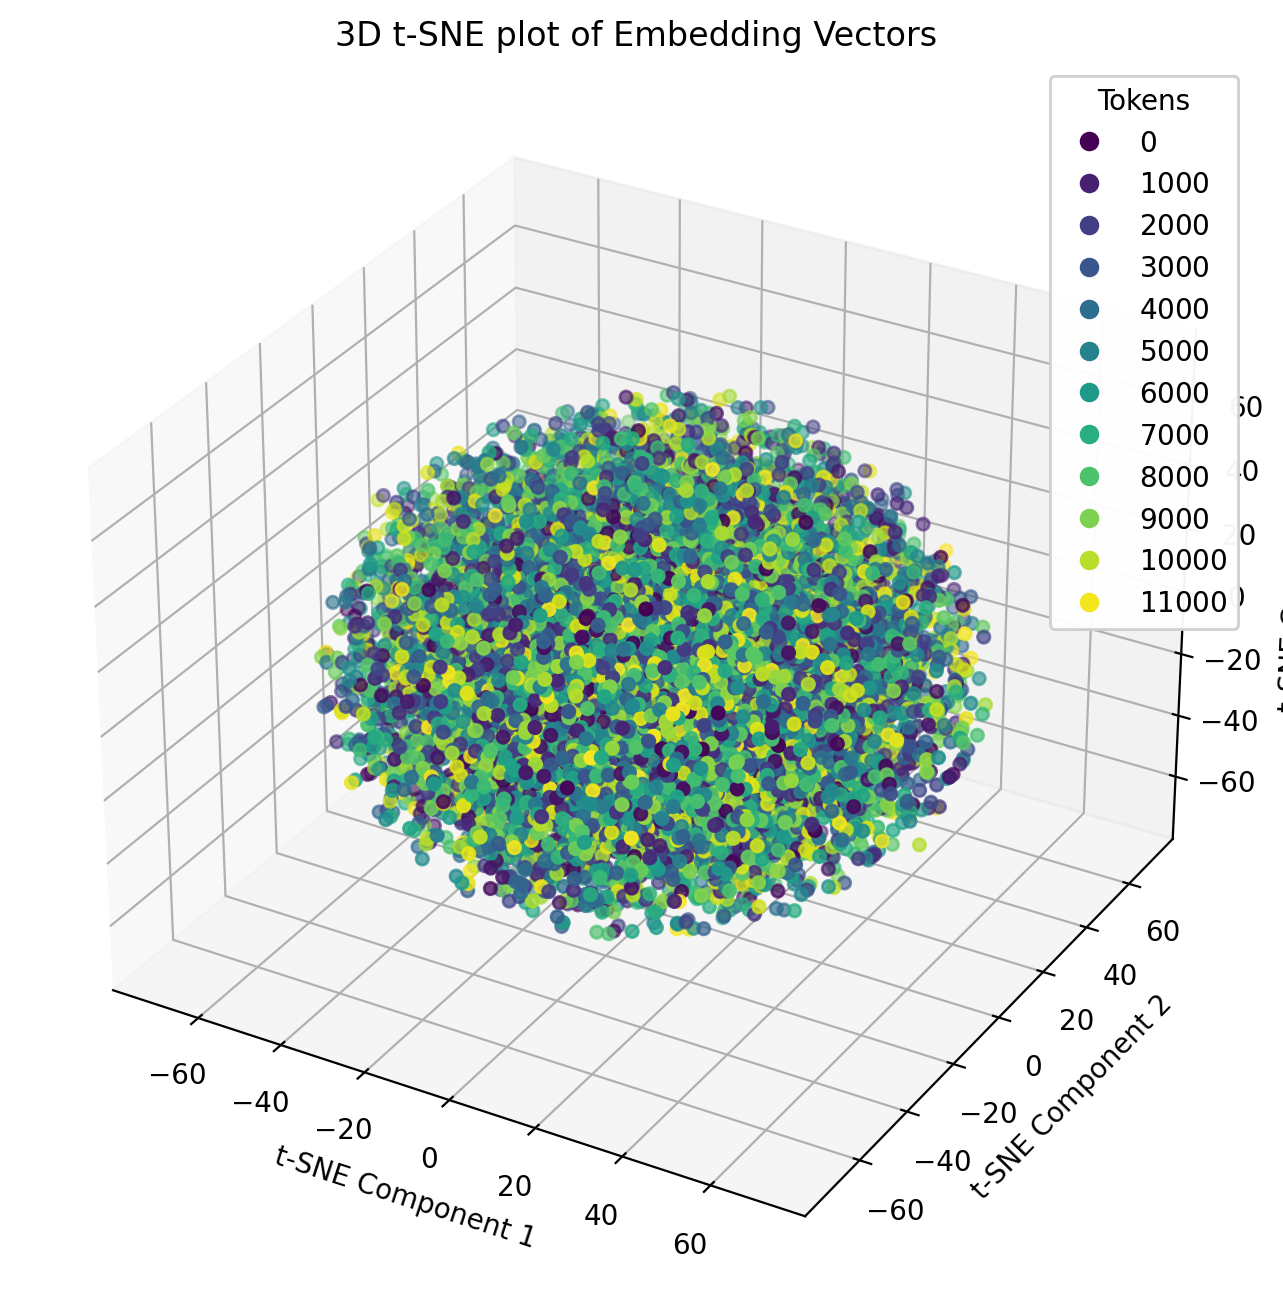

In [16]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()

In [17]:
import time
l1_lambda = 0.000007  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.00007)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(1000):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass


Epoch 0, Loss: 11.36911678314209
Epoch 10, Loss: 8.094866752624512
Epoch 20, Loss: 7.324602127075195
Epoch 30, Loss: 6.717498779296875
Epoch 40, Loss: 6.191910743713379
Epoch 50, Loss: 5.717959880828857
Epoch 60, Loss: 5.289666652679443
Epoch 70, Loss: 4.922623634338379
Epoch 80, Loss: 4.638477325439453
Epoch 90, Loss: 4.428347587585449
Epoch 100, Loss: 4.266784191131592
Epoch 110, Loss: 4.135399341583252
Epoch 120, Loss: 4.023609161376953
Epoch 130, Loss: 3.9252090454101562
Epoch 140, Loss: 3.836660385131836
Epoch 150, Loss: 3.755474805831909
Epoch 160, Loss: 3.6802830696105957
Epoch 170, Loss: 3.609762668609619
Epoch 180, Loss: 3.543025493621826
Epoch 190, Loss: 3.479341983795166
Epoch 200, Loss: 3.418342113494873
Epoch 210, Loss: 3.359773635864258
Epoch 220, Loss: 3.3035802841186523
Epoch 230, Loss: 3.2495460510253906
Epoch 240, Loss: 3.197754383087158
Epoch 250, Loss: 3.1482348442077637
Epoch 260, Loss: 3.1009836196899414
Epoch 270, Loss: 3.056013584136963
Epoch 280, Loss: 3.013374

In [18]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 jacob is this way can
 do you know my dear fellow i
 used to the truce of greeting and the laws a little
 to ze peace of which he had left a member at the square his
 
 
 his horse prince andrew had brought the last on his
 german i was told how an army of
 welllit the dying man lay a
 next excited with six standing and a russian soldier who felt quite


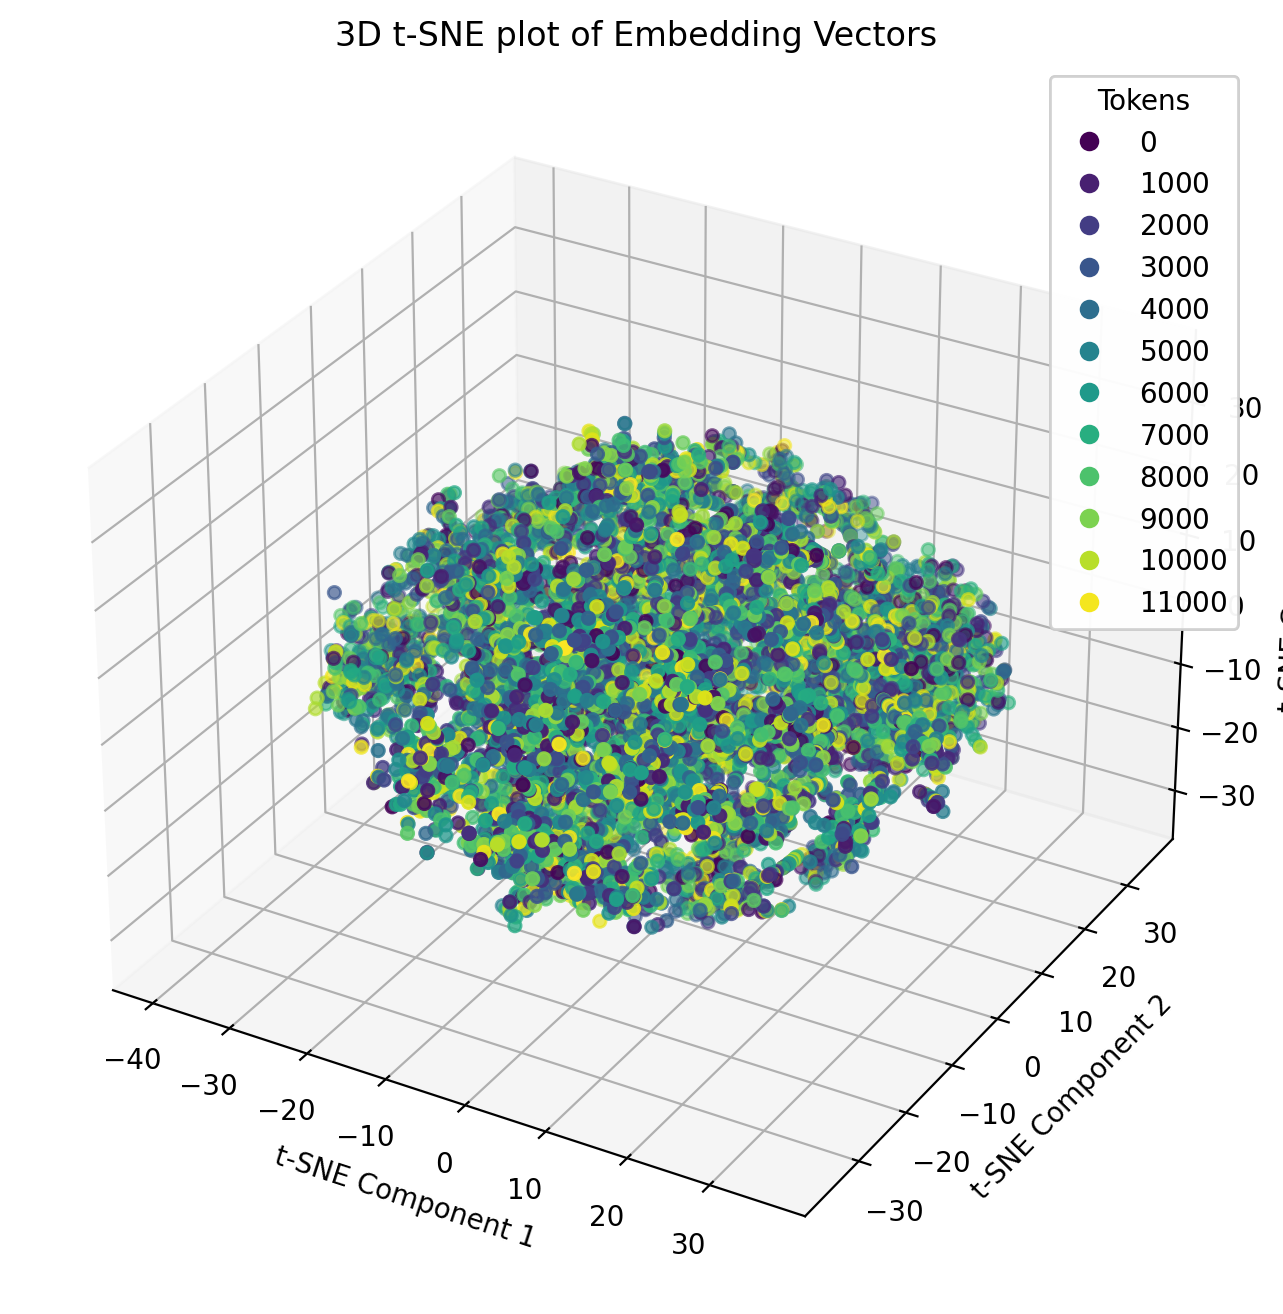

In [19]:
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [20]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_5_32_1024_r.pth")

In [21]:
model = model.to(device)